In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras import initializers
import tensorflow as tf

%matplotlib inline

In [2]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [3]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 15000
EMBEDDING_DIM = 200 #100
VALIDATION_SPLIT = 0.2
LOAD_MODEL = False # True
EVALUATION_MODE = False
RUNS = 1

In [4]:
# reading data
import tensorflow_datasets as tfds

import sys

sys.path.append(r"myutils")

from myutils import clean_doc


import os


#Load train dataset
DATASET = "imdb_reviews"   #'yelp_polarity_reviews'
train = tfds.as_numpy(tfds.load(DATASET, data_dir=f"{DATASET}", split="train", batch_size=-1))
X_train, y_train = [clean_doc(x.decode()) for x in train["text"]], train["label"]

# Load test dataset
test = tfds.as_numpy(tfds.load(DATASET, data_dir=f"{DATASET}", split="test", batch_size=-1))
X_test, y_test = [clean_doc(x.decode()) for x in test["text"]], test["label"]

print(f"Train samples: {len(X_train)}")
print(f"Test samples:  {len(X_test)}")

Train samples: 25000
Test samples:  25000


In [5]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

with open('model/tokenizer_rnn.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer has been saved.")

Number of Unique Tokens 121361


In [6]:
data1 = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


labels1 = to_categorical(np.asarray(y_train))
print('Shape of Data Tensor:', data1.shape)
print('Shape of Label Tensor:', labels1.shape)


Shape of Data Tensor: (25000, 1000)
Shape of Label Tensor: (25000, 2)


In [7]:
from myutils import create_glove_embeddings
emb_layer = create_glove_embeddings(
            embedding_dim  = EMBEDDING_DIM,
            max_num_words  = MAX_NB_WORDS,
            max_seq_length = MAX_SEQUENCE_LENGTH,
            tokenizer      = tokenizer
        )

Pretrained GloVe embedding is loading...
Found 400000 word vectors in GloVe embedding



In [8]:
if LOAD_MODEL:
    from keras.models import load_model

    model=load_model('model_rnn.h5')
    model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.SGD(),
              metrics=['acc'])
    model.summary()
else:
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = emb_layer(sequence_input)
    l_lstm = Bidirectional(LSTM(50))(embedded_sequences)
    preds = Dense(2, activation='softmax')(l_lstm)
    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.SGD(),
              metrics=['acc'])

    print("Bidirectional LSTM")
    model.summary()

Bidirectional LSTM
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 word_embedding (Embedding)  (None, 1000, 200)         3000000   
                                                                 
 bidirectional (Bidirectiona  (None, 100)              100400    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 3,100,602
Trainable params: 3,100,602
Non-trainable params: 0
_________________________________________________________________


In [9]:
if not EVALUATION_MODE:
    
    cp=ModelCheckpoint('model_rnn.h5',monitor='val_loss',verbose=1,save_best_only=True, mode="min")
    earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1)
    
    for i in range(RUNS):
        print(f"Running iteration {i+1}/{RUNS}")

        indices = np.arange(data1.shape[0])
        np.random.shuffle(indices)
        data = data1[indices]
        labels = labels1[indices]
        nb_validation_samples = int(VALIDATION_SPLIT * data1.shape[0])

        x_train = data[:-nb_validation_samples]
        y_train = labels[:-nb_validation_samples]
        x_val = data[-nb_validation_samples:]
        y_val = labels[-nb_validation_samples:]



        history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=50,callbacks=[cp,earlystop])

Running iteration 1/1
Epoch 1/15
400/400 [==============================] - ETA: 0s - loss: 0.6866 - acc: 0.5523
Epoch 1: val_loss improved from inf to 0.67563, saving model to model_rnn.h5
400/400 [==============================] - 927s 2s/step - loss: 0.6866 - acc: 0.5523 - val_loss: 0.6756 - val_acc: 0.6030
Epoch 2/15
400/400 [==============================] - ETA: 0s - loss: 0.6551 - acc: 0.6446
Epoch 2: val_loss improved from 0.67563 to 0.62822, saving model to model_rnn.h5
400/400 [==============================] - 894s 2s/step - loss: 0.6551 - acc: 0.6446 - val_loss: 0.6282 - val_acc: 0.6804
Epoch 3/15
400/400 [==============================] - ETA: 0s - loss: 0.5769 - acc: 0.7124
Epoch 3: val_loss improved from 0.62822 to 0.53761, saving model to model_rnn.h5
400/400 [==============================] - 903s 2s/step - loss: 0.5769 - acc: 0.7124 - val_loss: 0.5376 - val_acc: 0.7406
Epoch 4/15
400/400 [==============================] - ETA: 0s - loss: 0.5268 - acc: 0.7471
Epoch 4: 

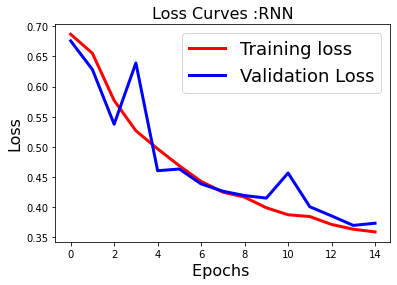

In [10]:
if not EVALUATION_MODE:
    fig1 = plt.figure()
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves :RNN',fontsize=16)
    fig1.savefig('loss_rnn.png')
    plt.show()

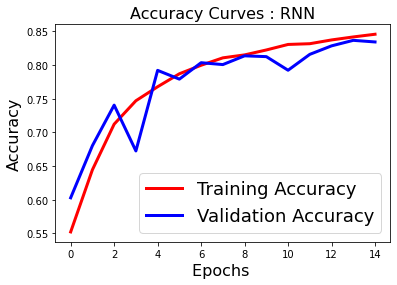

In [11]:
if not EVALUATION_MODE:
    fig2=plt.figure()
    plt.plot(history.history['acc'],'r',linewidth=3.0)
    plt.plot(history.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves : RNN',fontsize=16)
    fig2.savefig('accuracy_rnn.png')
    plt.show()

In [12]:
if not EVALUATION_MODE:
    from keras.utils.vis_utils import plot_model
    plot_model(model, to_file='rnn_model.png', show_shapes=True, show_layer_names=True)

In [13]:
if EVALUATION_MODE:
    from PIL import Image
    display(Image.open('rnn_model.png'))

In [14]:
from keras.models import load_model
# evaluation
with open('model/tokenizer_rnn.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
    
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test_word    = pad_sequences(
    sequences_test,
    maxlen  = MAX_SEQUENCE_LENGTH,
    padding = 'post'
)

X_test_word = X_test_word



test_loss = []
test_accs = []


cnn_ = load_model(f"model_rnn.h5")
score = cnn_.evaluate(X_test_word, to_categorical(y_test), verbose=1)
test_loss.append(score[0])
test_accs.append(score[1])
    
print(f"\nLoss / accuracy on testset: {np.mean(test_loss)} loss / {np.mean(test_accs)} acc")
print(f"Standard deviation: (+-{np.std(test_loss)}) loss / (+-{np.std(test_accs)}) acc")

782/782 [==============================] - 321s 409ms/step - loss: 0.6971 - acc: 0.5121

Loss / accuracy on testset: 0.6970992684364319 loss / 0.5121200084686279 acc
Standard deviation: (+-0.0) loss / (+-0.0) acc


In [16]:
if not os.path.exists('model'):
    os.mkdir('model')
with open('model/tokenizer_rnn.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer has been saved.")

tokenizer has been saved.


In [ ]:
#classes = model.predict(X_test, batch_size=50)